Agent Supervisor


In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [4]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [6]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

In [7]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

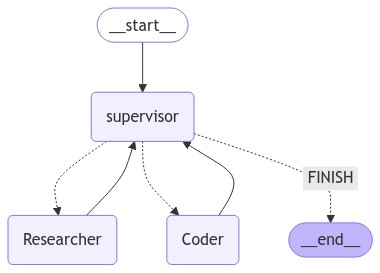

In [8]:
# 可视化图
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Error generating graph: {e}")


In [9]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='The code to print "Hello, World!" has been executed and it produced the following output:\n\n```\nHello, World!\n```', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [10]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### Research Report on Pikas\n\n#### Introduction\nPikas are small, herbivorous mammals belonging to the family Ochotonidae. They are closely related to rabbits and hares and are found in mountainous regions across North America and Asia. Known for their distinctive calls and industrious behavior, pikas play a significant role in their ecosystems.\n\n#### Habitat and Behavior\nPikas primarily inhabit cold, alpine environments, often residing in rocky terrains and talus slopes. They are well-adapted to these harsh conditions and do not hibernate during the winter. Instead, they collect and store vegetation in "haypiles" to sustain themselves through the colder months. This behavior, known as "haying," involves gathering grasses, sedges, and other plant materials to create caches of food. Pikas are diurnal and prefer cooler temperatures, typically foraging in shaded areas to avoid direct sunlig